# Using NLP in Identifying Monetary Policy Shocks

### This program aims to identify monetary policy shocks, by applying natural language processing techniques to FOMC (Federal Open Market Committee) documents that Federal Reserve staff prepare in advance of policy decisions.

##### Note: This is an attempt at Python replication of NLP in "Identifying Monetary Policy Shocks: A Natural Language Approach" by S. Borağan Aruoba and Thomas Drechsel, which was originally created in R.

In [18]:
!pip install PyPDF2
import os
import zipfile
import PyPDF2
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.util import ngrams
nltk.download('punkt_tab')
nltk.download('stopwords')
from collections import Counter, defaultdict
import pandas as pd
import re
from PyPDF2 import PdfReader
from datetime import datetime
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Mounting Google Drive

In [21]:
from google.colab import drive
import os
import time
import zipfile
import shutil
import time

# Unmount if already mounted
drive.flush_and_unmount()
time.sleep(2)

# Mount Google Drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/FOMC docs/FOMC docs.zip'

# Folder containing all Beigebook PDFs
all_pdfs_folder = '/content/drive/MyDrive/FOMC docs/extracted/FOMC docs'

test_folder = '/content/drive/MyDrive/FOMC docs/test_docs'
os.makedirs(test_folder, exist_ok=True)

# Years to include
start_year = 1996
end_year = 2016

# Function to copy a file with retries
def copy_file_with_retries(src, dst, retries=5, delay=5):
    for i in range(retries):
        try:
            shutil.copy(src, dst)
            return True
        except OSError as e:
            print(f"Attempt {i+1} failed to copy {os.path.basename(src)}: {e}")
            time.sleep(delay)
    print(f"Failed to copy {os.path.basename(src)} after {retries} retries.")
    return False


# Copy PDFs from 1996 to 2016 with retries
copied_count = 0
for filename in os.listdir(all_pdfs_folder):
    if filename.endswith('.pdf'):
        year_str = filename[:4]  # first 4 characters are the year
        if year_str.isdigit():
            year = int(year_str)
            if start_year <= year <= end_year:
                src_path = os.path.join(all_pdfs_folder, filename)
                dst_path = os.path.join(test_folder, filename)
                if copy_file_with_retries(src_path, dst_path):
                    copied_count += 1


print(f"Created test_docs folder with Beigebook PDFs from {start_year} to {end_year}.")
print(f"Total files copied: {copied_count}")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive
Created test_docs folder with Beigebook PDFs from 1996 to 2016.
Total files copied: 451


Global Constants

In [22]:
# Create string to match YYYY_MM_DD format of the PDFs and an empty dictionary for the dates and text.
date_pattern = r"\d{4}_\d{2}_\d{2}"
grouped_data = {}

# Lists of singles, doubles, and triples (unigrams, bigrams, and trigrams known generally as ngrams). The lists of tuples are economic concepts chosen by Drechsel and Aruoba. I also include ngrams that will have sentiments included and excluded.
singles = [('borrowing',), ('brazil',), ('banks',), ('canada',), ('credit',), ('china',), ('consumption',), ('construction',), ('currencies',), ('deposits',), ('employment',), ('equipment',), ('euro',), ('exports',), ('germany',), ('hiring',), ('hours',), ('housing',), ('imports',), ('inflation',), ('inventories',), ('investment',), ('japan',), ('liquidity',), ('loans',), ('leasing',), ('lending',), ('machinery',), ('mexico',), ('mortgage',), ('output',), ('productivity',), ('profits',), ('recovery',), ('reserves',), ('savings',), ('spread',), ('structures',), ('tourism',), ('unemployment',), ('utilization',), ('wages',), ('weather',), ('yield',), ('income',), ('gdp',), ('cpi',), ('nairu',), ('services',), ('bonds',), ('economy',), ('outlays',), ('financing',), ('assets',), ('finance',), ('shipments',), ('capacity',), ('office',), ('computers',), ('industries',), ('producers',), ('supply',), ('homes',), ('sectors',), ('agriculture',), ('merchandise',), ('investors',), ('aircraft',), ('stocks',), ('buildings',), ('cash',), ('trucks',), ('semiconductors',), ('farm',), ('uncertainty',), ('households',), ('crop',), ('apparel',), ('steel',), ('automotive',), ('metals',), ('permits',), ('commerce',), ('transportation',), ('municipal',), ('commodities',), ('corporations',), ('liabilities',), ('consumers',), ('firms',), ('trading',), ('corn',), ('asia',), ('taxes',), ('software',), ('mining',), ('losses',), ('jobs',), ('cars',), ('depreciation',), ('recession',), ('france',), ('korea',), ('italy',), ('lumber',), ('volatility',), ('wheat',), ('livestock',), ('rents',), ('petroleum',), ('traffic',), ('fuel',), ('plants',), ('technology',), ('argentina',), ('cattle',), ('crisis',), ('utilities',), ('travel',), ('payrolls',), ('factory',), ('transfers',), ('drought',), ('gold',), ('salaries',), ('cotton',), ('coal',), ('philippines',), ('singapore',), ('taiwan',), ('thailand',), ('soybean',), ('swaps',), ('harvest',), ('environment',), ('deflator',), ('delinquencies',), ('chemicals',), ('mergers',), ('rigs',), ('indonesia',), ('political',), ('peso',), ('retirement',), ('tobacco',), ('hurricane',), ('equities',), ('russia',), ('workers',), ('contractors',), ('borrowers',), ('brazilian',), ('bank',), ('banking',), ('bankers',), ('canadian',), ('chinese',), ('export',), ('german',), ('hires',), ('houses',), ('import',), ('inventory',), ('investments',), ('japanese',), ('loan',), ('lenders',), ('mortgages',), ('profit',), ('saving',), ('spreads',), ('wage',), ('yields',), ('durables',), ('manufacturers',), ('manufacturer',), ('treasuries',), ('gnp',), ('service',), ('asset',), ('computer',), ('building',), ('builders',), ('truck',), ('semiconductor',), ('farmers',), ('autos',), ('automobile',), ('metal',), ('soybeans',), ('christmas',)
 ]

doubles = [('employment', 'cost'), ('aggregate, demand'), ('auto', 'sales'), ('bond', 'issuance'), ('budget', 'deficit'), ('business', 'activity'), ('business', 'confidence'), ('business', 'spending'), ('capital', 'expenditures'), ('consumer', 'confidence'), ('current', 'account'), ('debt', 'growth'), ('defense', 'spending'), ('delinquency', 'rates'), ('developing', 'countries'), ('domestic', 'demand'), ('drilling', 'activity'), ('durable', 'goods'), ('economic', 'growth'), ('energy', 'prices'), ('equity', 'issuance'), ('equity', 'prices'), ('euro', 'area'), ('exchange', 'rate'), ('federal', 'debt'), ('financial', 'conditions'), ('financial', 'developments'), ('fiscal', 'policy'), ('fiscal', 'stimulus'), ('food', 'prices'), ('foreign', 'economies'), ('gas', 'prices'), ('gasoline', 'prices'), ('government', 'purchases'), ('home', 'prices'), ('home', 'sales'), ('hourly', 'compensation'), ('household', 'debt'), ('household', 'spending'), ('import', 'prices'), ('industrial', 'production'), ('industrial', 'supplies'), ('inflation', 'compensation'), ('inflation', 'expectations'), ('initial', 'claims'), ('input', 'prices'), ('intermediate', 'materials'), ('international', 'developments'), ('labor', 'market'), ('manufacturing', 'activity'), ('manufacturing', 'firms'), ('monetary', 'aggregates'), ('mortgage', 'interest'), ('natural', 'rate'), ('net', 'exports'), ('new', 'orders'), ('nondefense', 'capital'), ('oil', 'prices'), ('output', 'gap'), ('potential', 'output'), ('price', 'pressures'), ('producer', 'prices'), ('refinancing', 'activity'), ('residential', 'investment'), ('retail', 'prices'), ('retail', 'sales'), ('retail', 'trade'), ('share', 'prices'), ('social', 'security'), ('stock', 'market'), ('trade', 'balance'), ('trade', 'deficit'), ('trade', 'surplus'), ('treasury', 'securities'), ('treasury', 'yield'), ('vacancy', 'rates'), ('wholesale', 'prices'), ('wholesale', 'trade'), ('yield', 'curve'), ('foreign', 'exchange'), ('nominal', 'gdp'), ('core', 'inflation'), ('motor', 'vehicles'), ('financial', 'institutions'), ('depository', 'institutions'), ('credit', 'standards'), ('consumer', 'prices'), ('crude', 'oil'), ('loan', 'demand'), ('united', 'kingdom'), ('money', 'market'), ('market', 'participants'), ('commercial', 'paper'), ('housing', 'starts'), ('housing', 'activity'), ('natural', 'gas'), ('consumer', 'goods'), ('balance', 'sheet'), ('financial', 'markets'), ('economic', 'indicators'), ('final', 'sales'), ('credit', 'quality'), ('international', 'transactions'), ('finished', 'goods'), ('latin', 'america'), ('economic', 'outlook'), ('domestic', 'developments'), ('oil', 'imports'), ('home', 'equity'), ('headline', 'inflation'), ('raw', 'materials'), ('holiday', 'season'), ('inflationary', 'pressures'), ('loan', 'officer'), ('health', 'care'), ('economic', 'expansion'), ('economic', 'data'), ('canadian', 'dollar'), ('corporate', 'profits'), ('insurance', 'companies'), ('wage', 'pressures'), ('market', 'expectations'), ('consumer', 'spending'), ('car', 'sales'), ('vehicle', 'sales'), ('real', 'activity'), ('business', 'conditions',), ('economic', 'conditions'), ('capital', 'spending'), ('consumer', 'sentiment'), ('durable', 'equipment'), ('energy', 'price'), ('equity', 'price'), ('stock', 'prices'), ('stock', 'price'), ('exchange', 'rates'), ('food', 'price'), ('gas', 'price'), ('gasoline', 'price'), ('home', 'price'), ('house', 'prices'), ('house', 'price'), ('hourly', 'earnings'), ('import', 'price'), ('input', 'price'), ('labor', 'markets'), ('manufacturing', 'sector'), ('mortgage', 'rates'), ('oil', 'price'), ('potential', 'gdp'), ('producer', 'price'), ('retail', 'price'), ('share', 'price'), ('treasury', 'bills'), ('treasury', 'security'), ('treasury', 'yields'), ('vacancy', 'rate'), ('wholesale', 'price'), ('nominal', 'gnp'), ('thrift', 'institutions'), ('lending', 'standards'), ('consumer', 'price'), ('imported', 'oil'), ('crude', 'materials'), ('district', 'banks'), ('import', 'prices'), ('inflation', 'expectations'), ('inflation', 'compensation'), ('core', 'inflation'), ('headline', 'inflation'), ('loan', 'rates'), ('mortgage', 'rate'), ('unemployment', 'insurance'), ('national', 'income'), ('income', 'tax',), ('foreign', 'gdp'), ('asset', 'purchases'), ('oil', 'price'), ('oil', 'prices'), ('commodity', 'prices'), ('commodity', 'price')

]

triples = [('advanced', 'foreign', 'economies'), ('commercial', 'real', 'estate'), ('compensation', 'per', 'hour'), ('domestic', 'final', 'purchases'), ('domestic', 'financial', 'developments'), ('emerging', 'market', 'economies'), ('foreign', 'industrial', 'countries'), ('gross', 'domestic', 'purchases'), ('household', 'net', 'worth'), ('international', 'financial', 'transactions'), ('labor', 'force', 'participation'), ('major', 'industrial', 'countries'), ('market', 'interest', 'rates'), ('nondefense', 'capital', 'goods'), ('output', 'per', 'hour'), ('real', 'estate', 'activity'), ('real', 'estate', 'market'), ('real', 'interest', 'rate'), ('real', 'interest', 'rates'), ('residential', 'real', 'estate'), ('unit', 'labor', 'cost'), ('unit', 'labor', 'costs'), ('money', 'market', 'mutual'), ('foreign', 'net', 'purchases'), ('real', 'estate', 'markets'), ('gross', 'domestic', 'product'), ('gross', 'national', 'product'), ('foreign', 'direct', 'investment'), ('money', 'market', 'mutual')
]

# Define n-grams to include and exclude as dictionaries. Drechsel and Aruoba combine the sentiments of some economic concepts with the sentiments of select singles, doubles, and triples (ngrams). I set the economic concepts as values associated with main ngrams. Later, I add and/or subtract the sentiments of the values in include_dict and exclude_dict to form final_adjusted_sentiment.
include_dict = {
    "borrowing": ["borrowers"],
    "brazil": ["brazilian"],
    "banks": ["bank", "banking", "bankers"],
    "canada": ["canadian"],
    "china": ["chinese"],
    "consumption": [("consumer", "spending")],
    "exports": ["export"],
    "germany": ["german"],
    "hiring": ["hires"],
    "housing": ["houses"],
    "imports": ["import"],
    "inventories": ["inventory"],
    "investment": ["investments"],
    "japan": ["japanese"],
    "loans": ["loan"],
    "lending": ["lenders"],
    "mortgage": ["mortgages"],
    "profits": ["profit"],
    "savings": ["saving"],
    "spread": ["spreads"],
    "wages": ["wage"],
    "yield": ["yields"],
    ("auto", "sales"): [("car", "sales"), ("vehicle", "sales")],
    ("business", "activity"): [("business", "activity"), ("real", "activity"), ("business", "conditions"), ("economic", "conditions")],
    ("capital", "expenditures"): [("capital", "spending")],
    ("commodity", "prices"): [("commodity", "price")],
    ("consumer", "confidence"): [("consumer", "sentiment")],
    ("durable", "goods"): ["durables", ("durable", "equipment")],
    ("energy", "prices"): [("energy", "price")],
    ("equity", "prices"): [("equity", "price"), ("stock", "prices"), ("stock", "price")],
    ("exchange", "rate"): [("exchange", "rates")],
    ("food", "prices"): [("food", "price")],
    ("gas", "prices"): [("gas", "price")],
    ("gasoline", "prices"): [("gasoline", "price")],
    ("home", "prices"): [("home", "price"), ("house", "prices"), ("house", "price")],
    ("hourly", "compensation"): [("hourly", "earnings")],
    ("import", "prices"): [("import", "price")],
    ("input", "prices"): [("input", "price")],
    ("labor", "market"): [("labor", "markets")],
    ("manufacturing", "firms"): ["manufacturers", "manufacturer",("manufacturing", "sector")],
    ("mortgage", "interest"): [("mortgage", "rate"), ("mortgage", "rates")],
    ("oil", "prices"): [("oil", "price")],
    ("potential", "output"): [("potential", "gdp")],
    ("producer", "prices"): [("producer", "price")],
    ("retail", "prices"): [("retail", "price")],
    ("share", "prices"): [("share", "price")],
    ("treasury", "securities"): ["treasuries", ("treasury", "bills"), ("treasury", "security")],
    ("treasury", "yield"): [("treasury", "yields")],
    ("vacancy", "rates"): [("vacancy", "rate")],
    ("wholesale", "prices"): [("wholesale", "price")],
    ("real", "estate", "market"): [("real", "estate", "markets")],
    ("real", "interest", "rate"): [("real", "interest", "rates")],
    ("unit", "labor", "cost"): [("unit", "labor", "costs")],
    "gdp": [("gross", "domestic", "product"), "gnp", ("gross", "national", "product")],
    ("nominal", "gdp"): [("nominal", "gnp")],
    "services": ["service"],
    ("depository", "institutions"): [("thrift", "institutions")],
    "assets": ["asset"],
    ("credit", "standards"): [("lending", "standards")],
    "computers": ["computer"],
    "buildings": ["building", "builders"],
    ("consumer", "prices"): [("consumer", "price")],
    "trucks": ["truck"],
    "semiconductors": ["semiconductor"],
    "farm": ["farmers"],
    "automotive": ["autos", "cars", "automobile"],
    "metals": ["metal"],
    ("oil", "imports"): [("imported", "oil")],
    "soybean": ["soybeans"],
    ("raw", "materials"): [("crude", "materials")],
    ("holiday", "season"): ["christmas"]
}

exclude_dict = {
    "banks": [("district", "banks")],
    "credit": [("credit", "standards"), ("credit", "quality")],
    "employment": [("employment", "cost")],
    "euro": [("euro", "area")],
    "exports": [("net", "exports")],
    "housing": [("housing", "starts"), ("housing", "activity")],
    "imports": [("import", "prices")],
    "inflation": [("inflation", "expectations"), ("inflation", "compensation"), ("core", "inflation"), ("headline", "inflation")],
    "investment": [("residential", "investment"), ("foreign", "direct", "investment")],
    "loans": [("loan", "demand"), ("loan", "officer"), ("loan", "rates")],
    "mortgage": [("mortgage", "interest"), ("mortgage", "rates"), ("mortgage", "rate")],
    "output": [("output", "gap"), ("potential", "output"), ("output", "per", "hour")],
    "unemployment": [("unemployment", "insurance")],
    "wages": [("wage", "pressures")],
    "yield": [("yield", "curve"), ("treasury", "yield")],
    "income": [("national", "income"), ("income", "tax")],
    ("treasury", "yield"): [("yield", "curve")],
    ("advanced", "foreign", "economies"): [("foreign", "economies")],
    "gdp": [("nominal", "gdp"), ("potential", "gdp"), ("nominal", "gnp"), ("foreign", "gdp")],
    "assets": [("asset", "purchases")],
    ("crude", "oil"): [("oil", "price"), ("oil", "prices")],
    ("money", "market"): [("money", "market", "mutual")],
    ("natural", "gas"): [("gas", "price"), ("gas", "prices")],
    "commodities": [("commodity", "prices"), ("commodity", "price")],
    "firms": [("manufacturing", "firms")]
}

Functions

In [23]:
# Functions Block
import pandas as pd
from collections import defaultdict
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

# Load Loughran-McDonald dictionary
def load_lm_master_dictionary(filepath):
    df = pd.read_csv(filepath)
    df['Word'] = df['Word'].astype('string').fillna('')

    lm_lexicon = defaultdict(lambda: {"Negative": 0, "Positive": 0})

    for _, row in df.iterrows():
        word = row["Word"].lower()
        lm_lexicon[word]["Negative"] = int(row["Negative"])
        lm_lexicon[word]["Positive"] = int(row["Positive"])

    return lm_lexicon

# Find ngram sentiments
def find_ngram_sentiments_master(text_data_by_date, ngrams_with_n, lm_lexicon):
    all_sentiment_data = []
    total_words_per_date = {}

    ngram_list, n_values = zip(*ngrams_with_n)
    ngram_set = set(ngram_list)

    for date, text in text_data_by_date.items():
        words = word_tokenize(text.lower())
        total_words_per_date[date] = len(words)

        text_ngrams_dict = {n: list(ngrams(words, n)) for n in set(n_values)}

        sentiment_data = []
        for n_value in text_ngrams_dict:
            text_ngrams = text_ngrams_dict[n_value]
            for i, ngram in enumerate(text_ngrams):
                if ngram in ngram_set:
                    start = max(i - 10, 0)
                    end = min(i + n_value + 10, len(words))
                    context_words = words[start:end]
                    context_text = " ".join(context_words)

                    sentiment_score = (
                        1 if lm_lexicon[" ".join(ngram)]["Positive"] > 0 else
                        -1 if lm_lexicon[" ".join(ngram)]["Negative"] > 0 else
                        0
                    )

                    before_sentiment = sum(
                        1 if lm_lexicon[word]["Positive"] > 0 else -1 if lm_lexicon[word]["Negative"] > 0 else 0
                        for word in words[start:i]
                    )

                    after_sentiment = sum(
                        1 if lm_lexicon[word]["Positive"] > 0 else -1 if lm_lexicon[word]["Negative"] > 0 else 0
                        for word in words[i + n_value:end]
                    )

                    adjusted_sentiment = sentiment_score + before_sentiment + after_sentiment

                    sentiment_data.append({
                        "date": date,
                        "ngram": " ".join(ngram),
                        "context": context_text,
                        "base_sentiment": sentiment_score,
                        "before_sentiment": before_sentiment,
                        "after_sentiment": after_sentiment,
                        "adjusted_sentiment": adjusted_sentiment,
                        "n": n_value
                    })

        all_sentiment_data.extend(sentiment_data)

    full_df = pd.DataFrame(all_sentiment_data)
    full_df["total_words"] = full_df["date"].map(total_words_per_date)
    full_df["total_sentiment"] = full_df["adjusted_sentiment"].fillna(0)

    return full_df

# Apply inclusion/exclusion adjustments
def apply_inclusion_exclusion(row, adjusted_values, include_dict, exclude_dict):
    ngram_info = adjusted_values.get(
        (row["date"], row["ngram"]), {"adjusted_sentiment": 0, "total_words": 1}
    )

    base_sentiment = ngram_info["adjusted_sentiment"]
    total_words = ngram_info["total_words"]

    included_sentiment = sum(
        adjusted_values.get((row["date"], inc), {"adjusted_sentiment": 0})["adjusted_sentiment"]
        for inc in include_dict.get(row["ngram"], [])
    )

    excluded_sentiment = sum(
        adjusted_values.get((row["date"], exc), {"adjusted_sentiment": 0})["adjusted_sentiment"]
        for exc in exclude_dict.get(row["ngram"], [])
    )

    final_sentiment = base_sentiment + included_sentiment - excluded_sentiment

    return pd.Series({"final_adjusted_sentiment": final_sentiment, "total_words": total_words})

Main Execution Block

In [24]:
# Imports
import os
import re
from collections import defaultdict
from datetime import datetime
from PyPDF2 import PdfReader
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk import ngrams
import concurrent.futures

# Stopwords are downloaded
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Folder path
folder_path = '/content/drive/MyDrive/FOMC docs/test_docs'
date_pattern = r'\d{4}_\d{2}_\d{2}'  # YYYY_MM_DD pattern

# Worker function for one PDF
stop_words_set = set(stopwords.words('english'))

def process_pdf(pdf_file):
    """Extracts text from one PDF, cleans it, and returns (date, text)."""
    file_date_match = re.search(date_pattern, pdf_file)
    if not file_date_match:
        return None

    file_date = file_date_match.group()
    file_datetime = datetime.strptime(file_date, "%Y_%m_%d").date()

    pdf_path = os.path.join(folder_path, pdf_file)
    with open(pdf_path, 'rb') as file:
        reader = PdfReader(file)
        full_text = "".join(page.extract_text() for page in reader.pages)

    # --- NLP cleaning ---
    sent = sent_tokenize(full_text)
    words_1 = [word_tokenize(s) for s in sent]
    list_words = sum(words_1, [])

    token_words = [w for w in list_words if not (len(w) == 1 and w.lower() not in {"a", "i"})]
    token_words = [w for w in token_words if re.search(r'[aeiou]', w, re.I)]
    low_words = [w.lower() for w in token_words]
    remove_words = [w for w in low_words if w not in stop_words_set]
    punc_words = [w for w in remove_words if w.isalnum()]

    common_fixes = {
        'devel': 'development',
        'reserv': 'reserves',
        'dom': 'domestic',
        'purch': 'purchases',
        'prod': 'product',
        'cons': 'consumption',
        'prices3': 'prices',
        'econ': 'economic',
        'int': 'international',
        'pe': 'percent'
    }

    corrected_tokens = [common_fixes.get(w, w) for w in punc_words]
    cleaned_text = " ".join(corrected_tokens)

    return (file_datetime, cleaned_text)

# Run in parallel for PDFs
pdf_files = [f for f in os.listdir(folder_path) if f.endswith('.pdf')]
merged_text_by_date = defaultdict(str)

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(process_pdf, pdf_files))

# Merge results by date
for result in results:
    if result:
        date, text = result
        merged_text_by_date[date] += text + "\n"

# Load Loughran-McDonald Master Dictionary
lm_filepath = "/content/drive/MyDrive/FOMC docs/Loughran-McDonald_MasterDictionary_1993-2023.csv"
lm_lexicon = load_lm_master_dictionary(lm_filepath)

# Combine all ngrams
all_ngrams = [(ngram, 1) for ngram in singles] + \
             [(ngram, 2) for ngram in doubles] + \
             [(ngram, 3) for ngram in triples]

# Sentiment Analysis
df_all = find_ngram_sentiments_master(merged_text_by_date, all_ngrams, lm_lexicon)

# Aggregate by date/ngram
df_all = df_all.groupby(["date", "ngram"]).agg(
    adjusted_sentiment=("adjusted_sentiment", "sum"),
    total_words=("total_words", "first")
).reset_index()

# Create full date/ngram grid
all_dates = df_all["date"].unique()
all_ngrams_list = df_all["ngram"].unique()
full_index = pd.MultiIndex.from_product([all_dates, all_ngrams_list], names=["date", "ngram"])
full_df = pd.DataFrame(index=full_index).reset_index()

df_all = full_df.merge(df_all, on=["date", "ngram"], how="left")

# Create adjusted_values dictionary
adjusted_values = {
    (row["date"], row["ngram"]): {
        "adjusted_sentiment": row["adjusted_sentiment"],
        "total_words": row["total_words"]
    }
    for _, row in df_all.iterrows()
}

# Ensure include_dict and exclude_dict are defined (empty dicts if none)
include_dict = {}
exclude_dict = {}

# Apply inclusion/exclusion
df_all[["final_adjusted_sentiment", "total_words"]] = df_all.apply(
    apply_inclusion_exclusion,
    axis=1,
    adjusted_values=adjusted_values,
    include_dict=include_dict,
    exclude_dict=exclude_dict
)

# Fill missing values
df_all["final_adjusted_sentiment"] = df_all["final_adjusted_sentiment"].fillna(0)
df_all["total_words"] = df_all["total_words"].fillna(1)

# Scale & standardize
df_all["scaled_sentiment"] = df_all["final_adjusted_sentiment"] / df_all["total_words"]
df_all["standardized_sentiment"] = df_all.groupby("ngram")["scaled_sentiment"].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Pivot and export
pivot_df = df_all.pivot(index="date", columns="ngram", values="standardized_sentiment")
excel_file_path = '/content/sentiment_scores.xlsx'
pivot_df.to_excel(excel_file_path, sheet_name="Standardized Sentiment", index=True)

print(f"Sentiment scores exported to {excel_file_path}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Sentiment scores exported to /content/sentiment_scores.xlsx


Plotting

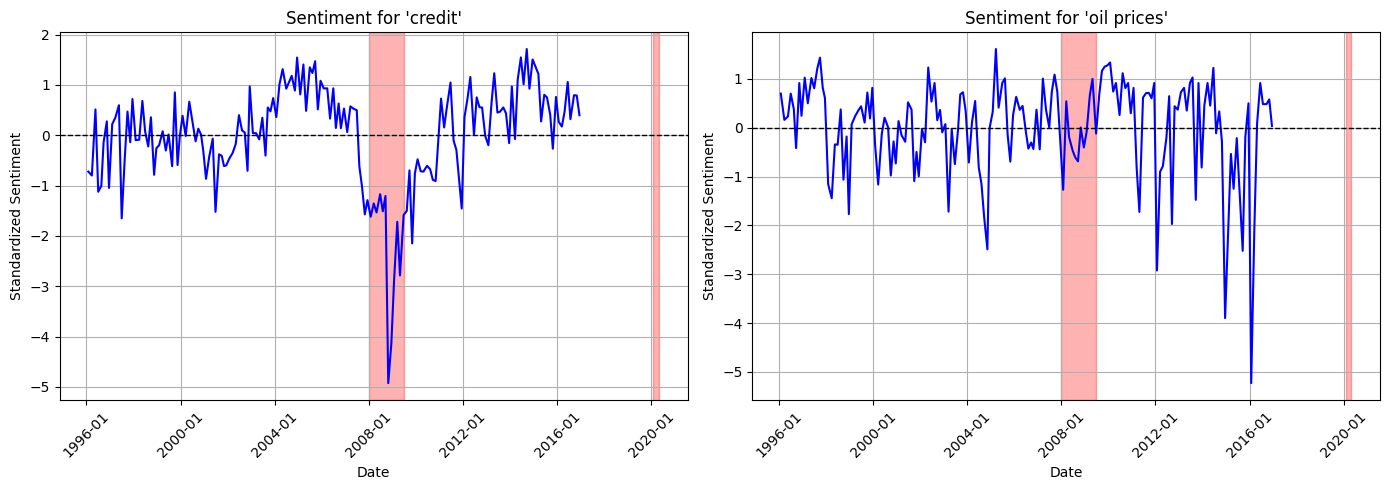

In [29]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot two n-grams' sentiment over time
ngrams_to_plot = ["credit", "oil prices"]  # replace with any ngrams needed

# Recession periods (as datetime.date)
recession_periods = [
    (pd.to_datetime("2008-01-01"), pd.to_datetime("2009-06-30")),
    (pd.to_datetime("2020-02-01"), pd.to_datetime("2020-04-30"))
]

# Ensure pivot_df index is datetime
pivot_df.index = pd.to_datetime(pivot_df.index)

# Create subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

for i, ngram in enumerate(ngrams_to_plot):
    if ngram in pivot_df.columns:
        axes[i].plot(pivot_df.index, pivot_df[ngram], linestyle='-', marker='', color='blue')
        axes[i].set_title(f"Sentiment for '{ngram}'")
        axes[i].set_xlabel("Date")
        axes[i].set_ylabel("Standardized Sentiment")
        axes[i].grid(True)

        # Format x-axis for dates
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        axes[i].tick_params(axis='x', rotation=45)

        # Add horizontal line at sentiment = 0
        axes[i].axhline(y=0, color='black', linestyle='--', linewidth=1)

        # Add shaded regions for recession periods
        for start, end in recession_periods:
            axes[i].axvspan(start, end, color='red', alpha=0.3)
    else:
        axes[i].text(0.5, 0.5, f"'{ngram}' not found", ha='center', va='center', fontsize=12)
        axes[i].set_title(f"'{ngram}' Not Found")
        axes[i].axis("off")

plt.tight_layout()
plt.show()